<figure style="text-align:center;">
  <img src="rover.png" alt="Mars Rover" style="max-width:700px; width:100%; height:auto;"/>
  <figcaption><strong>Figure:</strong> A rover navigating a linear Martian landscape.</figcaption>
</figure>

### Mars Rover Environment: TD(0) vs. First-Visit Monte Carlo

The **Mars Rover Environment**, implemented using Gymnasium, simulates a rover navigating across a linear Martian landscape. This environment is specifically designed to provide a simple yet challenging task for testing reinforcement learning algorithms. The rover must optimize its movements across probabilistic state transitions to reach a designated goal and maximize rewards.

---

### Features of the Notebook:
- **Policy Evaluation:** The true value function is determined using dynamic programming, serving as a benchmark.
- **Comparative Analysis:** Methods like **TD(0)** and **First-Visit Monte Carlo (FVMC)** are evaluated for value prediction accuracy.
- **Experiments:** Includes multiple experiments utilizing fixed and decaying step sizes (α), and uses root-mean-squared error (RMS) for performance assessment.
- **Visualizations:** Provides graphical visualizations showing how different algorithms converge under varying learning rates.

The notebook and its corresponding Mars Rover environment offer a hands-on approach to reinforcement learning research.

**Additional Material:**
The detailed implementation can be explored in the project repository: [Mars Rover GitHub Repository](https://github.com/MathPhysSim/MARS_ROVER).

---

### Authors

**Simon Hirlaender, Dipl.-Ing. Dr., BSc** – Head, SARL Team, IDA Lab, University of Salzburg
Contact: **simon.hirlaender@plus.ac.at**

**Olga Mironova, BA MSc** – Researcher, SARL Team, IDA Lab, University of Salzburg
Contact: **olga.mironova@plus.ac.at**


---

### Institutional Support

• **IDA Lab** – Intelligent Data Analytics Lab, University of Salzburg
  Website: <https://idalab.at>

• **SARL (Smart Analytics & Reinforcement Learning)** – Research team within IDA Lab
  Website: <https://sarl-plus.github.io>


---



In [1]:
import random
from itertools import count
from Mars_Rover_env import MarsRoverEnv
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange  # progress bar
from itertools import cycle

gamma = 1

pi_history = []
vi_history = []


### Policy Evaluation, Visualisation & Metrics

This cell bundles a compact but powerful toolkit that supports the entire notebook
pipeline—from computing the *ground-truth* optimum to printing human-readable
tables and measuring learning progress.

| Function | What it delivers |
|-----------|------------------|
| **`value_iteration(P, γ=1.0, θ=1e-10)`** | Classical dynamic-programming sweep that refines *V* until the Bellman optimality gap \< θ. Returns the optimal **Q\*** table, **V\*** vector and a greedy policy **π\***. |
| **`print_policy(π, P, action_symbols, n_cols, title)`** | Renders the policy as a grid of arrows (`<`, `v`, `>`, `^`), leaving terminal states blank for visual clarity. |
| **`print_state_value_function(V, P, n_cols, prec, title)`** | Prints *V* in the same grid layout so that high-value regions pop out at a glance. |
| **`print_action_value_function(Q, optimal_Q=None, …)`** | Pretty-prints Q-tables with optional columns for **Q\*** and per-state errors—ideal for debugging convergence. |
| **`get_policy_metrics(env, γ, π, goal_state, optimal_Q, n_episodes, max_steps)`** | Executes Monte-Carlo rollouts to report three headline figures: goal-reach rate [%], mean discounted return and mean regret versus **Q\***. |
| **`get_metrics_from_tracks(env, γ, goal_state, optimal_Q, π_track, coverage)`** | Samples a long policy trajectory (e.g. one policy per episode) and routes each sample through `get_policy_metrics`, giving you lightweight data points for learning-curve plots. |

**Why this matters**

1. **Reference oracle** — `value_iteration` supplies the gold standard against which every learning algorithm is compared.
2. **Readable diagnostics** — Printing helpers transform raw arrays into intuitive ASCII tables.
3. **Progress tracking** — Metric functions turn a policy into actionable numbers, enabling fair and reproducible comparisons across algorithms and hyper-parameters.

In [2]:


def rmse(x, y, dp=4): #  Compute and return the root-mean-squared error between arrays x and y
    return np.round(np.sqrt(np.mean((x - y) ** 2)), dp)

def policy_evaluation(env, policy, state_value=None):# Iteratively evaluate a given policy on the MRP `env` until the state-value function converges. Returns the final V and the number of sweeps performed.
    """Inplace policy evaluation. The existence and uniqueness of v are guaranteed as long as either gamma  < 1
        or eventual termination is guaranteed from all states under the policy pi. We have to exclude actions which lead to an infinite horizon or set gamma < 1 """
    if state_value is None:
        # initialize value table with zeros
        state_value = np.zeros(env.observation_space.n)

    # set the threshold
    threshold = 1e-20
    max_number_sweeps = 20000

    for sweep_nr in range(max_number_sweeps):
        delta = 0
        # for each state in the environment, select the action according to the policy and compute the value table
        for state in env.P:
            v = state_value[state]
            # action = policy[state]
            action = policy(state)
            # build the value table with the selected action
            state_value[state] = sum([trans_prob * (reward +
                                                    gamma * (
                                                            state_value[next_state] * (1 - done)))
                                      for trans_prob, next_state, reward, done in env.P[state][action]])
            delta = max(delta, abs(v - state_value[state]))
        if delta < threshold: break

    return state_value, sweep_nr

def learn_rate_decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):# Build a schedule that decays a learning rate from init_value to min_value over a fraction (decay_ratio) of max_steps, then holds it constant.
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

def generate_trajectory(pi, env, max_steps=200):# Run a single episode under policy pi in env, returning a list of (state, action, reward, next_state, done) tuples. 
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")
# ---------------------------------------------------------------------
#  Monte-Carlo state-value prediction (first-visit by default)
# ---------------------------------------------------------------------
def mc_prediction(pi, # Estimate V^pi using First-Visit or Every-Visit Monte Carlo.Returns final V, per-episode V_track, and all observed returns per state.
                  env,
                  gamma: float = 1.0,
                  init_alpha: float = 0.5,
                  min_alpha: float = 0.01,
                  alpha_decay_ratio: float = 0.5,
                  n_episodes: int = 500,
                  max_steps: int = 200,
                  first_visit: bool = True,
                  **kwargs):
    """
    First-visit or every-visit Monte-Carlo prediction of V^pi.

    Parameters
    ----------
    pi : Callable[[int], int]
        Deterministic policy mapping state -> action.
    env : gym.Env
        Environment following the OpenAI-Gym API.
    gamma : float
        Discount factor.
    init_alpha, min_alpha, alpha_decay_ratio : float
        Parameters for a decaying learning-rate schedule unless
        `constant_alpha` is supplied in **kwargs.
    n_episodes : int
        Number of episodes to sample.
    max_steps : int
        Per-episode trajectory cap.
    first_visit : bool
        If True, use first-visit MC; otherwise every-visit.
    **kwargs
        constant_alpha : float – use a fixed step-size.
        init_V : float   – initial value for all non-terminal states.

    Returns
    -------
    V : ndarray, shape (nS,)
        Estimated state-value function after `n_episodes`.
    V_track : ndarray, shape (n_episodes+1, nS)
        Snapshot of V after episode 0 (initial) and after each episode.
    targets : dict[int, list[float]]
        All returns (targets) seen for every state.
    """
    nS = env.observation_space.n
    discounts = np.logspace(0, max_steps, num=max_steps,
                            base=gamma, endpoint=False)

    # learning-rate schedule
    if 'constant_alpha' in kwargs:
        alphas = np.full(n_episodes, kwargs['constant_alpha'])
    else:
        alphas = learn_rate_decay_schedule(init_alpha,
                                           min_alpha,
                                           alpha_decay_ratio,
                                           n_episodes)

    V_init = kwargs.get('init_V', 0.0)
    V = np.full(nS, V_init, dtype=np.float64)
    V[0] = V[nS - 1] = 0.0                                   # terminals

    V_track = np.zeros((n_episodes + 1, nS), dtype=np.float64)
    V_track[0] = V                                           # episode-0 snapshot

    targets = {s: [] for s in range(nS)}

    for e in tqdm(range(n_episodes), leave=False, disable=True):
        trajectory = generate_trajectory(pi, env, max_steps)
        visited = np.zeros(nS, dtype=bool)

        for t, (state, _, reward, _, _) in enumerate(trajectory):
            if first_visit and visited[state]:
                continue
            visited[state] = True

            n_steps = len(trajectory) - t
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])  # return
            targets[state].append(G)

            V[state] += alphas[e] * (G - V[state])               # MC update

        V_track[e + 1] = V                                       # after episode e

    return V.copy(), V_track, targets


# ---------------------------------------------------------------------
#  TD(0) state-value prediction
# ---------------------------------------------------------------------
def td(pi,     # estimate V^pi using one-step TD(0).Returns final V, per-episode V_track, and all TD targets per state.
       env,
       gamma: float = 1.0,
       init_alpha: float = 0.5,
       min_alpha: float = 0.01,
       alpha_decay_ratio: float = 0.5,
       n_episodes: int = 500,
       **kwargs):
    """
    TD(0) prediction of V^pi with optional constant or decaying step-size.

    Parameters mirror `mc_prediction` (minus `max_steps`, `first_visit`).
    """
    nS = env.observation_space.n

    if 'constant_alpha' in kwargs:
        alphas = np.full(n_episodes, kwargs['constant_alpha'])
    else:
        alphas = learn_rate_decay_schedule(init_alpha,
                                           min_alpha,
                                           alpha_decay_ratio,
                                           n_episodes)

    V_init = kwargs.get('init_V', 0.0)
    V = np.full(nS, V_init, dtype=np.float64)
    V[0] = V[nS - 1] = 0.0                                     # terminals

    V_track = np.zeros((n_episodes + 1, nS), dtype=np.float64)
    V_track[0] = V                                             # episode-0 snapshot

    targets = {s: [] for s in range(nS)}

    for e in tqdm(range(n_episodes), leave=False, disable=True):
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)

            td_target = reward + gamma * V[next_state] * (not done)
            targets[state].append(td_target)

            V[state] += alphas[e] * (td_target - V[state])
            state = next_state

        V_track[e + 1] = V                                      # after episode e

    return V.copy(), V_track, targets


### Plotting Helpers — Tracking the Learning Dynamics

| Function | Role |
|-----------|------|
| **`plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=7)`** | Draws how the estimated state-value **V(s)** evolves across episodes. A random, yet informative subset of states ( ≤ `limit_items`) is chosen from those whose final value exceeds `limit_value`, keeping the figure uncluttered. If `V_true` is provided, each chosen state also gets a horizontal reference line for its true value. Optional `log=True` switches the *x*-axis to log scale. |
| **`plot_targets(targets, init_state, title)`** | Visualises the bootstrapped *targets* produced during learning for a single `init_state`. Each point shows the target value at a particular update step, while a black horizontal line marks the true value for context. |

#### How `plot_value_function` works

1. **State selection** – Picks up to `limit_items` states with non-trivial final values ( > `limit_value`).
2. **Colour & style cycling** – Uses independent colour and line-style generators so multiple series remain distinguishable.
3. **True-value overlay** – If `V_true` is supplied, a thin solid line is drawn first, ensuring estimates are plotted on top.
4. **Legend tiling** – Breaks long legends into columns (`per_col = 25`) so they never spill off-canvas, then re-inserts them manually.
5. **Log option** – A single flag toggles logarithmic scaling on the episode axis, useful when early-stage dynamics matter most.

#### How `plot_targets` works

1. Extracts the sequence of target values for `init_state`.
2. Draws a horizontal true-value line for instant error inspection.
3. Uses a colour-mapped scatter plot (`viridis`) to encode magnitude directly in the marker colour.

These two routines give you an immediate, visual sense of **convergence speed**, **bias** and **variance** throughout the learning process—crucial for diagnosing why an algorithm succeeds or stalls.m

In [3]:
# Visualise how the estimated state-value function V(s) changes over time
# (rows of V_track) and optionally compare those estimates to the true /
# optimal values V_true.  Only a subset of “interesting” states is plotted
# to keep the figure readable.

def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=7):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-", "--", ":", "-."])
    colorcycler = cycle(["lime", "blue", "dodgerblue", "red", 'orange', 'orange'])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values,
                                  min(len(valid_values), limit_items),
                                  replace=False)
    plt.figure(figsize=(8, 5))
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = f'v({i})'
            color = next(colorcycler)
            plt.axhline(y=V_true[i], linestyle='-', linewidth=1, color=color)

    colorcycler = cycle(["lime", "blue", "dodgerblue", "red", 'orange', 'orange'])
    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        color = next(colorcycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, ls=line_type, label=label, linewidth=1, color=color)
        legends.append(p)

    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx + per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('Value Function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.tight_layout()
    plt.show()


def plot_targets(targets, init_state, title):
    x = range(len(targets[init_state]))
    y = targets[init_state]

    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=1)
    plt.text(int(x[-1] * 1.02), V_true[init_state] + .01, label)

    plt.scatter(x, y,
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4)
    plt.title(title)

    plt.ylabel('Target value')
    plt.xlabel('Estimate sequence number')
    plt.show()


### Experiment Setup


1. **Reproducibility (`SEEDS`)**
   `SEEDS = range(10)` creates a list of ten integer seeds (0 – 9).
   • Each algorithm run can pick one of these seeds to initialise NumPy / Python RNGs, giving *independent yet repeatable* trials for confidence-interval plots.

2. **Environment instantiation (`env`)**
   `MarsRoverEnv(...)` spins up a miniature 5-state rover world with:
   • `p_backward = 0.5` – the rover moves one step backward 50 % of the time when an action fails.
   • `p_stay    = 0`   – no probability mass on “stay in place”; every failed move results in a backward slip.

This small, highly stochastic setup is ideal for quick debugging and unit tests before scaling to larger state spaces.```

In [4]:
SEEDS = range(10)
env = MarsRoverEnv(n_states=5, p_backward=0.5, p_stay=0)

FVMC vs. TD(0) – Script Walk-Through
------------------------------------

Purpose
• Compare First-Visit Monte-Carlo (FVMC) with TD(0) under a fixed “always-left” policy.
• Five random seeds, 1 000 episodes each, track V-estimates, compute RMSE against V*, and plot learning curves plus target scatters.

Key Steps
1. Policy
   LEFT, RIGHT = range(2)
   pi = lambda s: LEFT        # deterministic, always move left

2. True value function
   V_true = policy_evaluation(env, pi)[0]

3. Hyper-parameters
   γ            = 1.0         # no discount
   n_episodes   = 1000
   V_init       = 5.5
   α_MC = α_TD  = 0.15

4. FVMC loop
   For each seed in SEEDS:
     • reset RNGs
     • run mc_prediction(...)
     • store final V_fvmc and full trajectory V_track_fvmc
   After the loop: average results across seeds.

5. Diagnostics for FVMC
   • print_state_value_function(V_fvmc, P)
   • plot_value_function(..., V_track_fvmc, V_true)
   • rmse(V_fvmc, V_true)

6. TD(0) loop
   Identical to FVMC but calls td(...).

7. Learning-curve comparison
   • mean_RMSE_TD vs. mean_RMSE_MC on the same plot.

8. Target scatter plots
   plot_targets(targets_fvmc, init_state, 'FVMC target sequence')
   plot_targets(targets_td,  init_state, 'TD target sequence')

Outcome
• Produces state-value grids, per-state learning curves, RMSE timelines, and target scatters to visualise convergence speed, bias, and variance for both algorithms.
# Compare First-Visit Monte-Carlo and TD(0) on the Mars-Rover MRP under a fixed “always-left” policy.
# For five random seeds we track V-estimates over 1 000 episodes, compute RMSE against the true V*,
# and plot learning curves plus per-state target scatter to show bias/variance differences.


LEFT, RIGHT = range(2)
pi = lambda s: {
    0: LEFT, 1: LEFT, 2: LEFT, 3: LEFT, 4: LEFT, 5: LEFT, 6: LEFT
}[s]

# we use policy_evaluation here, are there alternatives?
V_true = policy_evaluation(env, pi)[0]
print(V_true)
constant_alpha_mc = 0.15
constant_alpha_td = 0.15
V_init = 5.5

init_state = env.reset()

gamma = 1.0
n_episodes = 1000
P = env.P

V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed);
    np.random.seed(seed);
    env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes,
                                                       # constant_alpha=constant_alpha_mc,
                                                       init_V=V_init)
    V_fvmcs.append(V_fvmc);
    V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)

print_state_value_function(V_fvmc, P, n_cols=7)
plot_value_function('FVMC estimator as a function of episodes\n vs. the true value function',
                    V_track_fvmc, V_true, log=False)
print('RMSE FVMC learning:', rmse(V_fvmc, V_true))

V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True, disable=True):
    random.seed(seed);
    np.random.seed(seed);
    env.seed(seed)

    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes,
                                      # constant_alpha=constant_alpha_td,
                                      init_V=V_init)
    V_tds.append(V_td);
    V_track_tds.append(V_track_td)

V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)

print_state_value_function(V_td, P, n_cols=7)
print()
print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE TD learning:', rmse(V_td, V_true))

plot_value_function('TD estimator as a function of episodes\n vs. the true value function', V_track_td, V_true,
                    log=False)

plt.plot(np.mean(np.sqrt(np.mean((V_track_tds - V_true) ** 2, axis=0)), axis=1),
         label=f'TD $alpha=${constant_alpha_td}')
plt.plot(np.mean(np.sqrt(np.mean((V_track_fvmcs - V_true) ** 2, axis=0)), axis=1),
         label=f'FVMC $alpha=${constant_alpha_mc}')
plt.legend()
plt.grid()
plt.show()

plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

plot_targets(targets_td, init_state, title='TD target sequence')


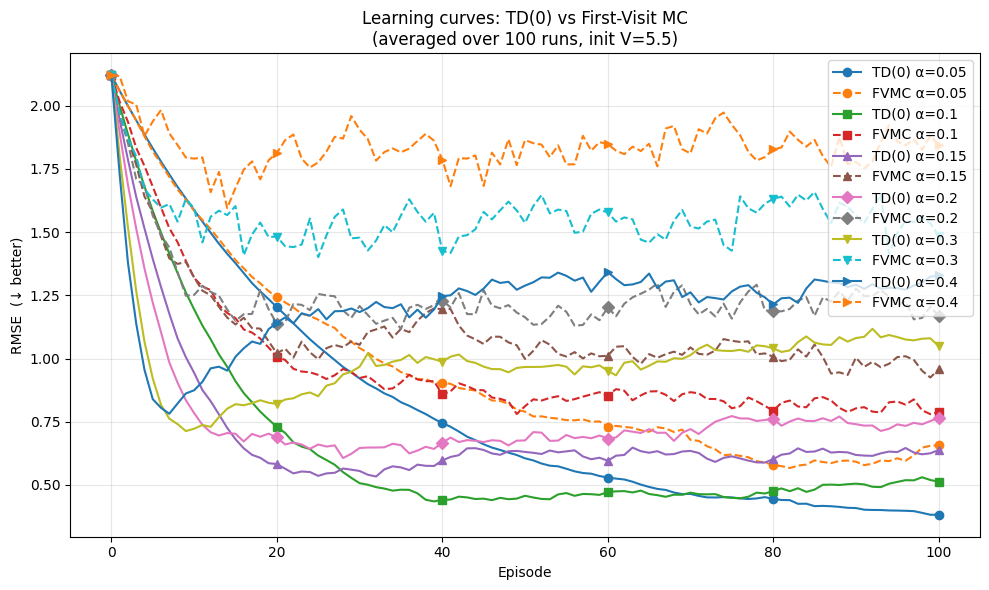

In [5]:
# This block benchmarks TD(0) and First-Visit Monte-Carlo over six fixed step-sizes (α) on the Mars-Rover MRP.  
# For each α we run 100 independent learning curves of 100 episodes, compute the RMSE against the exact value
# function, average across runs, and plot the resulting TD (solid) versus FVMC (dashed) error trajectories.
# ------------------------------------------------------------
# experiment parameters
# ------------------------------------------------------------
ALPHAS        = [0.05, 0.10, 0.15, 0.20, 0.30, 0.40]   # constant step-sizes to compare
N_EPISODES    = 100                  # length of each learning curve
N_RUNS        = 100                  # Monte-Carlo repetitions
GAMMA         = 1.0
INIT_V        = 5.5

LEFT, RIGHT = range(2)
pi = lambda s: {0: LEFT, 1: LEFT, 2: LEFT, 3: LEFT, 4: LEFT, 5: LEFT, 6: LEFT}[s]

# ------------------------------------------------------------
# reference value function (exact policy evaluation)
# ------------------------------------------------------------
V_ref, _ = policy_evaluation(env, pi)

non_terminal = [s for s in range(env.observation_space.n) if s not in (0, env.observation_space.n-1)]

def run_method(method, alpha):
    """
    Run one TD or FVMC trial and return the per-episode RMSE vector.
    """
    V, V_track, _ = method(
        pi, env,
        gamma=GAMMA,
        n_episodes=N_EPISODES,
        constant_alpha=alpha,
        init_V=INIT_V
    )
    # V_track has shape (N_EPISODES+1, nS); skip the first row if you
    # don't want episode-0 in the RMSE curve.
    err = np.sqrt(
        ((V_track[:, non_terminal] - V_ref[non_terminal]) ** 2).mean(axis=1)
    )
    return err

# ------------------------------------------------------------
# main loop: average over runs
# ------------------------------------------------------------
rmse_td   = {α: np.zeros(N_EPISODES+1) for α in ALPHAS}
rmse_mc   = {α: np.zeros(N_EPISODES+1) for α in ALPHAS}

for run in tqdm(range(N_RUNS), desc='Runs', disable=True):
    # new random seeds each run (optional):
    np.random.seed(run)
    env.seed(run)

    for α in ALPHAS:
        rmse_td[α] += run_method(td,         α)
        rmse_mc[α] += run_method(mc_prediction, α)

# average
for α in ALPHAS:
    rmse_td[α] /= N_RUNS
    rmse_mc[α] /= N_RUNS

# ------------------------------------------------------------
# plot
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))


marker_cycle = cycle(['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h'])
markers = {α: next(marker_cycle) for α in ALPHAS}

for α in ALPHAS:
    plt.plot(rmse_td[α],  label=f'TD(0) α={α}',  marker=markers[α], markevery=20, linewidth=1.5)
    plt.plot(rmse_mc[α],  label=f'FVMC α={α}',  linestyle='--',    marker=markers[α], markevery=20)

plt.xlabel('Episode')
plt.ylabel('RMSE  (↓ better)')
plt.title('Learning curves: TD(0) vs First-Visit MC\n(averaged over 100 runs, init V=5.5)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

runs:   0%|          | 0/100 [00:00<?, ?it/s]

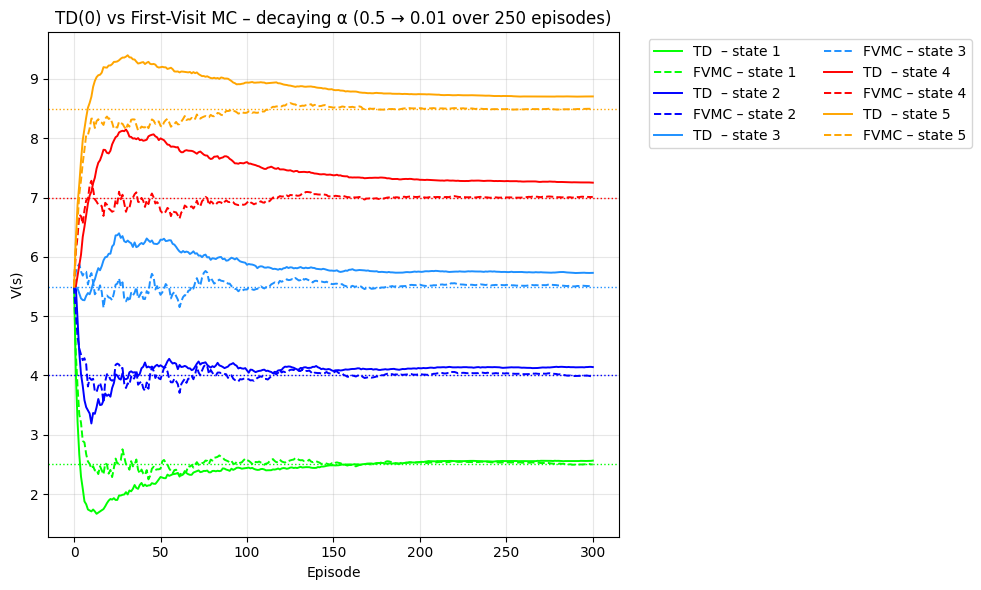

In [6]:
# This block compares TD(0) and First-Visit Monte-Carlo when the step-size α decays
# from 0.5 → 0.01 over the first 250 of 300 episodes.  For each of 100 random seeds
# the code records the full value-trajectory of every state, accumulates the results,
# and averages them so we can later plot per-state learning curves for both methods.

# ──────────────────────────────────────────────────────────────────────────
#   Per-state learning curves – decaying α   (TD(0)  vs  First-Visit MC)
# ──────────────────────────────────────────────────────────────────────────
# experiment settings
N_EPISODES = 300
INIT_ALPHA = 0.5
MIN_ALPHA = 0.01
DECAY_STEPS = 250
ALPHA_RATIO = DECAY_STEPS / N_EPISODES  # = 0.5
N_RUNS = 100
GAMMA = 1.0
INIT_V = 5.5

# environment & policy
env = MarsRoverEnv(n_states=5, p_backward=0.5, p_stay=0)
LEFT, RIGHT = range(2)
π = lambda s: {0: LEFT, 1: LEFT, 2: LEFT, 3: LEFT, 4: LEFT, 5: LEFT, 6: LEFT}[s]

# “ground-truth” value function (exact policy evaluation)
V_true, _ = policy_evaluation(env, π)

nS = env.observation_space.n
non_terminal = [s for s in range(nS) if s not in (0, nS - 1)]  # five states

track_td = np.zeros((N_EPISODES + 1, nS))
track_mc = np.zeros_like(track_td)

# Monte-Carlo repetitions
for run in trange(N_RUNS, desc='runs'):
    np.random.seed(run);
    env.seed(run)

    _, Vtrack_td, _ = td(π, env,
                         gamma=GAMMA,
                         init_alpha=INIT_ALPHA,
                         min_alpha=MIN_ALPHA,
                         alpha_decay_ratio=ALPHA_RATIO,
                         n_episodes=N_EPISODES,
                         init_V=INIT_V)

    _, Vtrack_mc, _ = mc_prediction(π, env,
                                    gamma=GAMMA,
                                    init_alpha=INIT_ALPHA,
                                    min_alpha=MIN_ALPHA,
                                    alpha_decay_ratio=ALPHA_RATIO,
                                    n_episodes=N_EPISODES,
                                    init_V=INIT_V)

    track_td += Vtrack_td
    track_mc += Vtrack_mc

track_td /= N_RUNS
track_mc /= N_RUNS
# ─── One–figure summary: all five states on the same axes ────────────────
plt.figure(figsize=(10, 6))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
colors = (["lime", "blue", "dodgerblue", "red", 'orange', 'orange'])

for k, s in enumerate(non_terminal):
    plt.plot(track_td[:, s],
             color=colors[k],
             linewidth=1.4,
             label=f'TD  – state {s}')
    plt.plot(track_mc[:, s],
             color=colors[k],
             linestyle='--',
             linewidth=1.4,
             label=f'FVMC – state {s}')
    plt.axhline(V_true[s],
                color=colors[k],
                linestyle=':',
                linewidth=1)

plt.xlabel('Episode')
plt.ylabel('V(s)')
plt.title('TD(0) vs First-Visit MC – decaying α (0.5 → 0.01 over 250 episodes)')
plt.grid(alpha=.3)
plt.legend(ncol=2, bbox_to_anchor=(1.04, 1), loc='upper left')
plt.tight_layout()
plt.show()